Bootstrapped Zero-Coupon Curve (Using Swap Data):
Maturity 0.2500 years: 2.3710%
Maturity 0.3330 years: 3.5256%
Maturity 0.4166 years: 2.8133%
Maturity 0.5000 years: 2.2962%
Maturity 0.6660 years: 2.5555%
Maturity 0.9166 years: 2.4163%
Maturity 1.2500 years: 2.1925%
Maturity 1.5000 years: 2.1829%
Maturity 1.7500 years: 2.1812%
Maturity 2.0000 years: 2.1865%
Maturity 2.2000 years: 2.2498%
Maturity 3.0000 years: 2.2501%
Maturity 4.0000 years: 2.3292%
Maturity 5.0000 years: 2.3833%
Maturity 6.0000 years: 2.4406%
Maturity 7.0000 years: 2.4917%
Maturity 8.0000 years: 2.5397%
Maturity 9.0000 years: 2.5859%
Maturity 10.0000 years: 2.6270%
Maturity 11.0000 years: 2.6653%
Maturity 12.0000 years: 2.6983%
Maturity 15.0000 years: 2.7642%
Maturity 20.0000 years: 2.7444%
Maturity 25.0000 years: 2.6598%
Maturity 30.0000 years: 2.5676%

Zero-Coupon Curve (Yearly Values):
Year 0: 0.0000%
Year 1: 2.3603%
Year 2: 2.1865%
Year 3: 2.2501%
Year 4: 2.3292%
Year 5: 2.3833%
Year 6: 2.4406%
Year 7: 2.4917%
Year

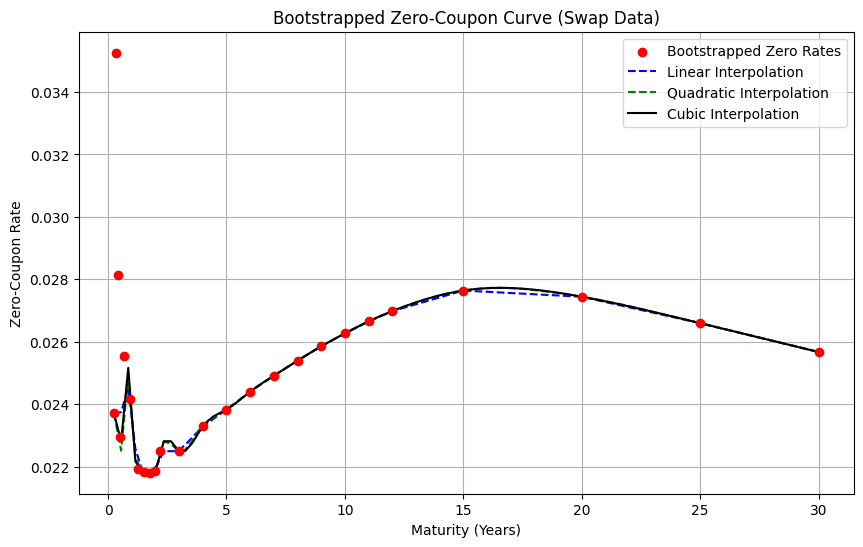

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.interpolate import interp1d, CubicSpline

class Instrument:
    def __init__(self, maturity, rate):
        self.maturity = maturity
        self.rate = rate

class Swap(Instrument):
    def __init__(self, maturity, fixed_rate):
        super().__init__(maturity, fixed_rate)

class Bootstrapping:
    def __init__(self, instruments):
        self.instruments = sorted(instruments, key=lambda x: x.maturity)
        self.zero_rates = {}

    def interpolate_yield(self, maturity):
        maturities = sorted(self.zero_rates.keys())
        rates = [self.zero_rates[m] for m in maturities]
        if len(maturities) < 2:
            raise ValueError("There are not enough points to interpolate.")
        if len(maturities) == 2:
            return np.interp(maturity, maturities, rates)
        else:
            spline = interp1d(maturities, rates, kind='quadratic', fill_value="extrapolate")
            return spline(maturity)

    def solve_zero_rate_swap(self, swap):
        T = swap.maturity
        dt = 0.25
        time_points = list(np.arange(dt, T, dt))
        if T not in time_points:
            time_points.append(T)
        time_points = sorted(time_points)
        def equation(r):
            total_value = 0
            for t in time_points:
                if t < T:
                    if t in self.zero_rates:
                        discount_factor = np.exp(-self.zero_rates[t] * t)
                    else:
                        ri = self.interpolate_yield(t)
                        discount_factor = np.exp(-ri * t)
                    total_value += swap.rate * discount_factor * dt
                else:
                    discount_factor = np.exp(-r * t)
                    total_value += swap.rate * discount_factor * dt + discount_factor
            return total_value - 1.0
        r_T = fsolve(equation, 0.02)[0]
        return r_T

    def build_curve(self):
        for instrument in self.instruments:
            if isinstance(instrument, Swap):
                rate = self.solve_zero_rate_swap(instrument)
                self.zero_rates[instrument.maturity] = rate
        return self.zero_rates

    def interpolate(self, method='linear'):
        maturities = np.array(list(self.zero_rates.keys()))
        rates = np.array(list(self.zero_rates.values()))
        if method == 'linear':
            self.interpolation_func = interp1d(maturities, rates, kind='linear', fill_value="extrapolate")
        elif method == 'quadratic':
            self.interpolation_func = interp1d(maturities, rates, kind='quadratic', fill_value="extrapolate")
        elif method == 'cubic':
            self.interpolation_func = CubicSpline(maturities, rates, bc_type='natural')
        else:
            raise ValueError("Interpolation method not supported.")

    def get_rate(self, maturity):
        if maturity in self.zero_rates:
            return self.zero_rates[maturity]
        elif hasattr(self, 'interpolation_func'):
            return self.interpolation_func(maturity)
        else:
            raise ValueError("Interpolation not defined. Run the interpolate() method before requesting a rate.")

def plot_zero_curve(bootstrap):
    maturities = np.sort(np.unique(np.array(list(bootstrap.zero_rates.keys()))))
    rates = np.array([bootstrap.zero_rates[m] for m in maturities])
    plt.figure(figsize=(10, 6))
    plt.scatter(maturities, rates, color='red', label='Bootstrapped Zero Rates', zorder=3)
    fine_maturities = np.linspace(min(maturities), max(maturities), 100)
    bootstrap.interpolate(method='linear')
    linear_rates = [bootstrap.get_rate(m) for m in fine_maturities]
    plt.plot(fine_maturities, linear_rates, linestyle='--', color='blue', label='Linear Interpolation')
    bootstrap.interpolate(method='quadratic')
    quadratic_rates = [bootstrap.get_rate(m) for m in fine_maturities]
    plt.plot(fine_maturities, quadratic_rates, linestyle='--', color='green', label='Quadratic Interpolation')
    bootstrap.interpolate(method='cubic')
    cubic_rates = [bootstrap.get_rate(m) for m in fine_maturities]
    plt.plot(fine_maturities, cubic_rates, linestyle='-', color='black', label='Cubic Interpolation')
    plt.xlabel("Maturity (Years)")
    plt.ylabel("Zero-Coupon Rate")
    plt.title("Bootstrapped Zero-Coupon Curve (Swap Data)")
    plt.legend()
    plt.grid(True)
    plt.show()

instruments = [
    Swap(0.25, 0.02378),
    Swap(0.333, 0.02355),
    Swap(0.4166, 0.02351),
    Swap(0.5, 0.02303),
    Swap(0.666, 0.02276),
    Swap(0.9166, 0.02226),
    Swap(1.25, 0.022),
    Swap(1.5, 0.02191),
    Swap(1.75, 0.02189),
    Swap(2.0, 0.02194),
    Swap(2.2, 0.02207),
    Swap(3.0, 0.0226),
    Swap(4.0, 0.02329),
    Swap(5.0, 0.02387),
    Swap(6.0, 0.0244),
    Swap(7.0, 0.02489),
    Swap(8.0, 0.02534),
    Swap(9.0, 0.02577),
    Swap(10.0, 0.02615),
    Swap(11.0, 0.0265),
    Swap(12.0, 0.0268),
    Swap(15.0, 0.0274),
    Swap(20.0, 0.02733),
    Swap(25.0, 0.02669),
    Swap(30.0, 0.02605)
]

if __name__ == '__main__':
    bootstrap = Bootstrapping(instruments)
    zero_curve = bootstrap.build_curve()
    print("Bootstrapped Zero-Coupon Curve (Using Swap Data):")
    for m, r in sorted(zero_curve.items()):
        print(f"Maturity {m:.4f} years: {r:.4%}")
    bootstrap.interpolate(method='linear')
    print("\nZero-Coupon Curve (Yearly Values):")
    for year in range(0, 31):
        if year == 0:
            rate = 0.0
        else:
            rate = bootstrap.get_rate(year)
        print(f"Year {year}: {rate:.4%}")
    plot_zero_curve(bootstrap)
